<a href="https://colab.research.google.com/github/lrzhang/cs634MidtermProject/blob/master/Housing_Price_Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Housing Prices for the Ames Data Set 

**CS 634  - Prof. Pantelis Monogloudis**

**Lee Zhang, Imran Hasmi, Jalaj Sharmat**

We will utilize the methods of machine learning to predict the sale price for houses based on the Ames data set. This project as an applied exercise in data engineering and data science, specifically utilising the tools of feature selection, feature engineering, and modeling through linear regression. While we explore a number of different methodologies, we found the following techniques to have the highest yield:

1. Feature Selection -  The search for redundant features, that is the first time I built the simplest model, I found it by chance. At that time, I manually tried which feature is good, which feature is bad, and found two bad features, which have been used until the end and surprisingly useful all the time. Deleting these two features will increase the score of this model again. [We learn alot of the techniques here from Comprehensive data visulization by Pedro Marcelino.](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
2. Feature Engineering - Filling in missing values, which can effectively improve the score. We try different methods such as filling of PoolQC, or pool quality, with categorical values based on the mode.  We also take lengths to normalize the data. The exploration of outliers, the outliers proposed above are not the best for this model, you can try to add new outliers, or reduce the old outliers, there will be some outlier combination for you to increase your score again.

3. Linear Regression - We try different regression algorithms provided by the Pandas library and found that Lasso regression works the best. [Serigne's kernal on stacking leads us to stack the regression models](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard). We find that by stacking the models and then applying weights to normalize our model to the training set, we minimize the RMSE.

At the end, we are able to achieve a top 2% RMSE of 0.1105. 

## Groundwork for the libraries and data pipeline

In [0]:
# Importing data processing and visualization 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# algorithm
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
# training
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# import dataset from current runtime
from google.colab import files
import io
# Dataset is now stored in a Pandas Dataframe
train =  pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission =  pd.read_csv('sample_submission.csv')

KeyboardInterrupt: ignored

Let us confirm by printing out the features available to us. We also will start to visualize the data by seeing the distribution of the label, SalePrice.

In [0]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

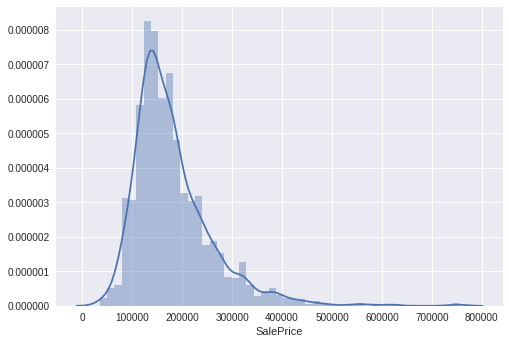

In [0]:
sns.distplot(train['SalePrice']);
train['SalePrice'].describe()

## Feature Visualization and Selection

We check to see if there is any correlation between different data types. We see that the multiple fields that describe the basement and Garage seem to contain similar data and so we wont need to analyze each one, and can pick the best features to use as the variables in our model.

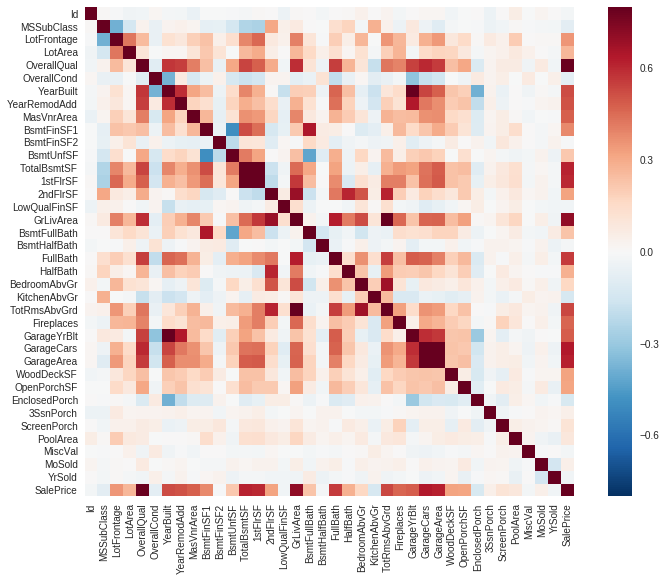

In [0]:
#Correlation Matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

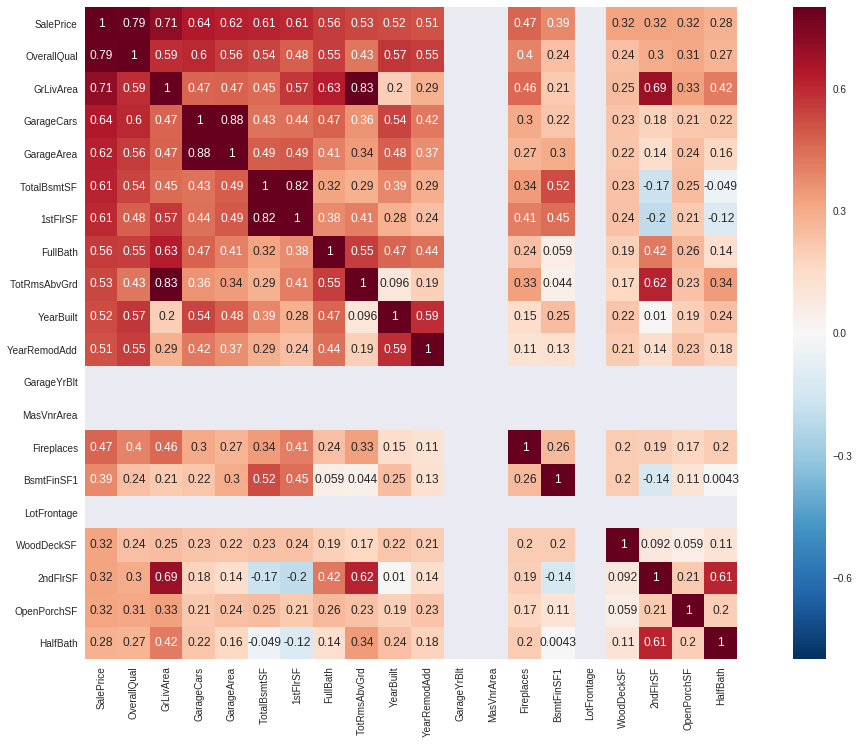

In [0]:
#Correlation Matrix
k = 20
corrmat = train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(cm, vmax=.8, annot=True, square=True, yticklabels=cols.values, xticklabels=cols.values);

Looking at the correlation map we see that several columns influence SalePrice. We want to see how each column individually influence saleprice and then also how they influence each other. More importantly, we can now being to choose the top 8 

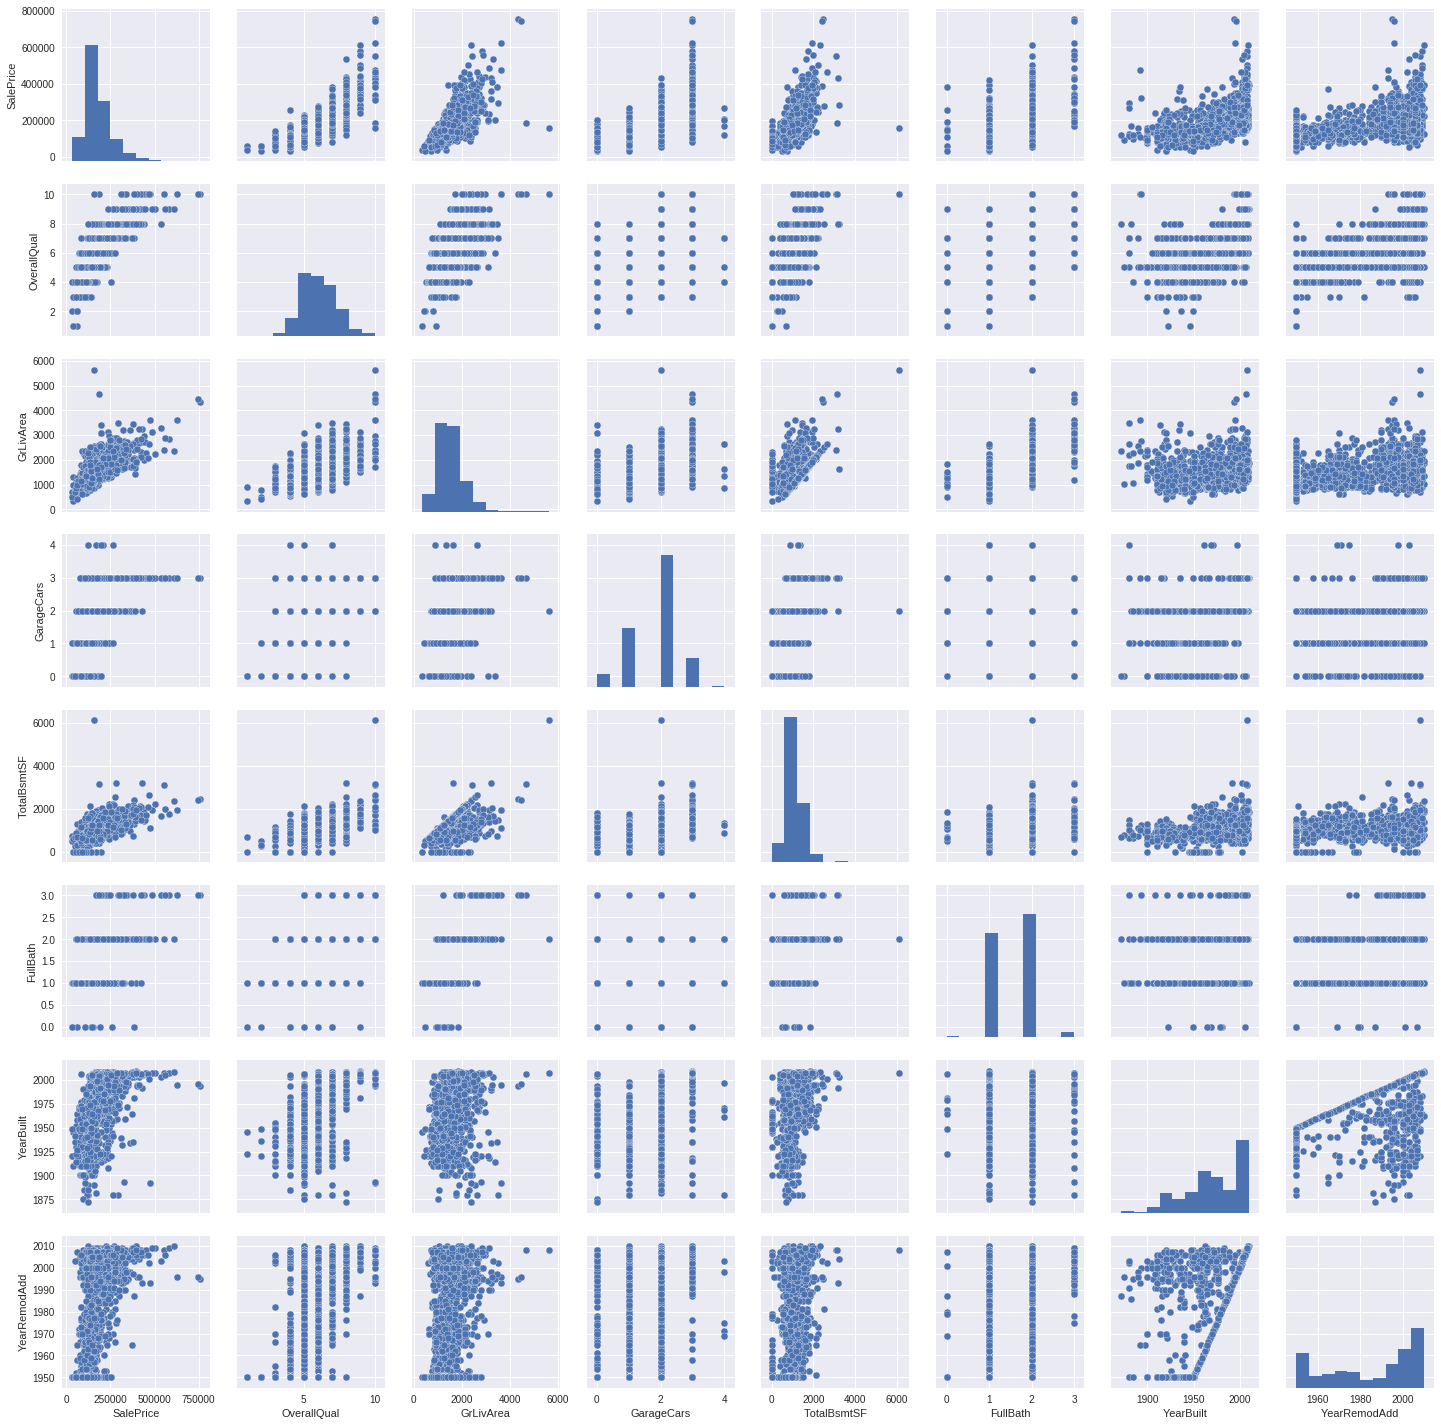

In [0]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd']
sns.pairplot(train[cols], size = 2.5)
plt.show();

We should check to see if we have missing data and if they correspond to the correlation matrix above. For example, if we have data for GarageArea but not GarageYrBlt, we can remove the latter and focus on data we do have. In cases where the data carries high importance, we will interpolate missing values.

First let us see how much data is missing from the features we have selected:

In [0]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


##Feature Engineering - Filling in Missing Values
From the above table, we are checking the percentage of labels that have the most missing values. Now that we have an understanding of the different features and can see which carry the highest importance, we will now perform feature engineering to allow us to regress the data. The overall goal here is to choose which values to drop, and which to interpolate and what values to use in the interpolation (categorial, mode, mean). 

First we will create a dataframe with all both the train and test sets and visualize these missing values.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,BsmtFullBath,BsmtHalfBath
27,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,0.0,0.0
580,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1.0,0.0
725,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,0.0,1.0
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,0.0,0.0
888,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,0.0,0.0
1064,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,0.0,0.0


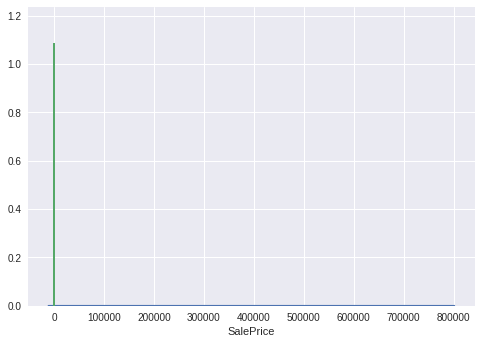

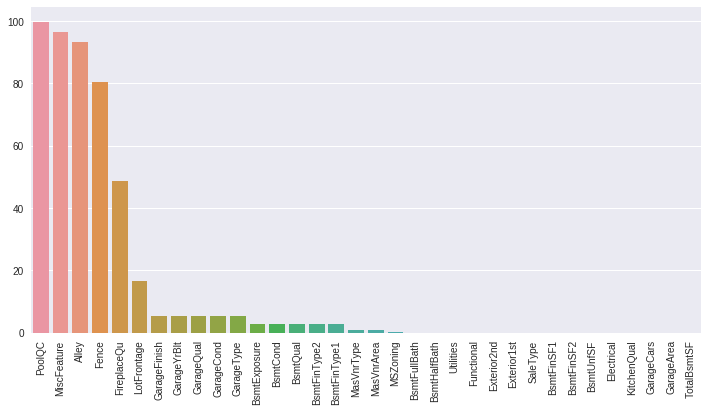

In [0]:
sns.distplot(train.SalePrice)

sns.distplot(np.log(train.SalePrice + 1))

all_data = pd.concat((train.drop(["SalePrice"], axis=1), test))
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation="90")
sns.barplot(x=all_data_na.index, y=all_data_na)

all_data[all_data.PoolArea != 0][["PoolArea", "PoolQC"]]

all_data[all_data.MiscVal > 10000][["MiscFeature", "MiscVal"]]

all_data[(all_data.GarageType.notnull()) & (all_data.GarageYrBlt.isnull())][["Neighborhood", "YearBuilt", "YearRemodAdd", "GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual", "GarageCond"]]

train.loc[[332, 948]][["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "BsmtFullBath", "BsmtHalfBath"]]

test.loc[[27, 580, 725, 757, 758, 888, 1064]][["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "BsmtFullBath", "BsmtHalfBath"]]

#plt.scatter(train.Utilities, train.SalePrice)

We can see that PoolQC contains the most missing values. Looking further, we see that in pool datapoints we have number of zero value but in pool data set **960,1043,1139** are diffrrent case so we assining missing value to them

In [0]:
y = train["SalePrice"]
y = np.log(y+1)

# PoolQC 
test.loc[960, "PoolQC"] = "Fa"
test.loc[1043, "PoolQC"] = "Gd"
test.loc[1139, "PoolQC"] = "Fa"

In [0]:
# Garage
test.loc[666, "GarageYrBlt"] = 1979
test.loc[1116, "GarageYrBlt"] = 1979
 
test.loc[666, "GarageFinish"] = "Unf"
test.loc[1116, "GarageFinish"] = "Unf"
 
test.loc[1116, "GarageCars"] = 2
test.loc[1116, "GarageArea"] = 480
 
test.loc[666, "GarageQual"] = "TA"
test.loc[1116, "GarageQual"] = "TA"
 
test.loc[666, "GarageCond"] = "TA"
test.loc[1116, "GarageCond"] = "TA"



We are filling  the missing value of 666 and 116. Because they have a detached garrage and no year built. So we are assigning them that value.

Now we are replacing  the missing vlaues in the remaining features. Specifically the missing value of PoolQC, Alley, FireplaceQu, LotFrontange, Garage, Bsmt, Masvnr, MiscFeature, Fence, Utilities and other. Missing values have a very abberent effect on model training because we know that linear regression models are harmed by missing values. 

In [0]:
# PoolQC
train = train.fillna({"PoolQC": "None"})
test = test.fillna({"PoolQC": "None"})
 
# Alley
train = train.fillna({"Alley": "None"})
test = test.fillna({"Alley": "None"})
 
# FireplaceQu
train = train.fillna({"FireplaceQu": "None"})
test = test.fillna({"FireplaceQu": "None"})
 
# LotFrontage
train = train.fillna({"LotFrontage": 0})
test = test.fillna({"LotFrontage": 0})
 
# Garage
train = train.fillna({"GarageType": "None"})
test = test.fillna({"GarageType": "None"})
train = train.fillna({"GarageYrBlt": 0})
test = test.fillna({"GarageYrBlt": 0})
train = train.fillna({"GarageFinish": "None"})
test = test.fillna({"GarageFinish": "None"})
test = test.fillna({"GarageCars": 0})
test = test.fillna({"GarageArea": 0})
train = train.fillna({"GarageQual": "None"})
test = test.fillna({"GarageQual": "None"})
train = train.fillna({"GarageCond": "None"})
test = test.fillna({"GarageCond": "None"})
 
# Bsmt
train = train.fillna({"BsmtQual": "None"})
test = test.fillna({"BsmtQual": "None"})
train = train.fillna({"BsmtCond": "None"})
test = test.fillna({"BsmtCond": "None"})
train = train.fillna({"BsmtExposure": "None"})
test = test.fillna({"BsmtExposure": "None"})
train = train.fillna({"BsmtFinType1": "None"})
test = test.fillna({"BsmtFinType1": "None"})
train = train.fillna({"BsmtFinSF1": 0})
test = test.fillna({"BsmtFinSF1": 0})
train = train.fillna({"BsmtFinType2": "None"})
test = test.fillna({"BsmtFinType2": "None"})
test = test.fillna({"BsmtFinSF2": 0})
test = test.fillna({"BsmtUnfSF": 0})
test = test.fillna({"TotalBsmtSF": 0})
test = test.fillna({"BsmtFullBath": 0})
test = test.fillna({"BsmtHalfBath": 0})
 
# MasVnr
train = train.fillna({"MasVnrType": "None"})
test = test.fillna({"MasVnrType": "None"})
train = train.fillna({"MasVnrArea": 0})
test = test.fillna({"MasVnrArea": 0})
 
# MiscFeature,Fence,Utilities
train = train.drop(["Fence", "MiscFeature", "Utilities"], axis=1)
test = test.drop(["Fence", "MiscFeature", "Utilities"], axis=1)
 
# other
test = test.fillna({"MSZoning": "RL"})
test = test.fillna({"Exterior1st": "VinylSd"})
test = test.fillna({"Exterior2nd": "VinylSd"})
train = train.fillna({"Electrical": "SBrkr"})
test = test.fillna({"KitchenQual": "TA"})
test = test.fillna({"Functional": "Typ"})
test = test.fillna({"SaleType": "WD"})


## Regression Modeling and Stacking
We have now finished the feature engineering and can move onto fit the model with the goal of removing outliers. First we generate our training and test dummy data sets. These sets have encoded the categorical data, allowing us to use it in our regression. Note that we combined both the training and test datasets into one dataframe to reduce code length when applying our outlier removal.

Due to the prescense of multicollinearity of the errors, we decide to use ridge regression to provide some regularisation. Afterwards we fit the model and calculate the standard deviation error for all values and remove those values outside three standard deviations. 


In [0]:
#We create our dummy set by encoding categoricals and dropping the header information.
train_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]
test_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]

#Create a ridge regression using the training values
rr = Ridge(alpha=10)
rr.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

#Calculating residuals and then identifying outliers as those that exist past 3 sigmas.
y_pred = rr.predict(train_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers1 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers1

array([  30,   88,  142,  277,  308,  328,  365,  410,  438,  462,  495,
        523,  533,  581,  588,  628,  632,  681,  688,  710,  714,  728,
        774,  812,  874,  898,  916,  935,  968,  970, 1062, 1168, 1170,
       1181, 1182, 1298, 1324, 1383, 1423, 1432, 1453])

We visualize the outliers in our model using a scatterplot. The outliers are in red.

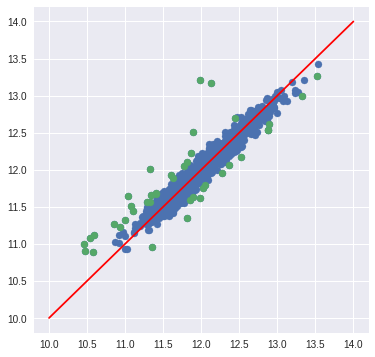

In [0]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers1], y_pred[outliers1])
plt.plot(range(10, 15), range(10, 15), color="red")

Now we decide to regression using elastic net

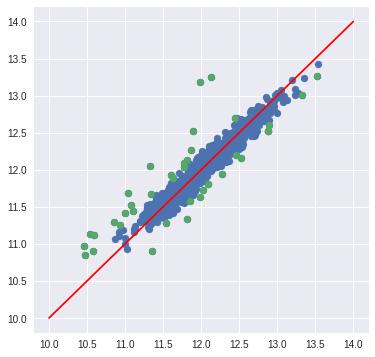

In [0]:
er = ElasticNet(alpha=0.001, l1_ratio=0.58)
er.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

y_pred = er.predict(train_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers2 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers2

plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers2], y_pred[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")

Now we validate the outliers between ridge and elastic net regression. The union of those two sets are our true outliers as they cannot be predicted by either regression model. We then drop those outliers.

In [0]:
outliers = []
for i in outliers1:
    for j in outliers2:
        if i == j:
            outliers.append(i)
outliers

train = train.drop([30, 88, 142, 277, 328, 410, 462, 495, 523, 533, 581, 588, 628, 632, 681, 688, 710, 714, 728, 774, 812, 874, 898, 916, 968, 970, 1181, 1182, 1298, 1324, 1383, 1423, 1432, 1453])
y = train["SalePrice"]
y = np.log(y+1)

Using this new dataframe, we regress using a variety of models: Gradient Boosting; XGBoost; Lasso; and Ridge.

In [0]:
train_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]
test_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]

gbr = GradientBoostingRegressor(max_depth=4, n_estimators=150)
gbr.fit(train_dummies, y)
np.sqrt(-cross_val_score(gbr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

xgbr = XGBRegressor(max_depth=5, n_estimators=400)
xgbr.fit(train_dummies, y)
np.sqrt(-cross_val_score(xgbr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

lsr = Lasso(alpha=0.00047)
lsr.fit(train_dummies, y)
np.sqrt(-cross_val_score(lsr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

rr = Ridge(alpha=13)
rr.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.09161386485828463

We see that the models give us different errors with Lasso giving us the lowest cross-validation score (root mean squared error).

We decide to stack these models and observe the results. The weights given to each model are arbitrary but we decide to weigh the Gradient Boosted with a 10% weight due to it's high error.

In [0]:
train_predict = 0.1 * gbr.predict(train_dummies) + 0.3 * xgbr.predict(train_dummies) + 0.3 * lsr.predict(train_dummies) + 0.3 * rr.predict(train_dummies)

Using this combined model we do some manual modification based on visualization of the data. We see from the scatterplot that the regression does not accurately capture data poitns at the bottom quantile as it does with the top quantile. There may be some real-life explanation of the cheapest houses not always following a certain regression equation. Therefore we apply a weight for that quantile. In this example we play with 99% and then decrease, eventually settling on 96%. 

In [0]:
plt.figure(figsize=(6, 6))
plt.scatter(y, train_predict)
plt.plot(range(10, 15), range(10, 15), color="red")

q1 = pd.DataFrame(train_predict).quantile(0.0042)
pre_df = pd.DataFrame(train_predict)
pre_df["SalePrice"] = train_predict
pre_df = pre_df[["SalePrice"]]
pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.99
train_predict = np.array(pre_df.SalePrice)
plt.figure(figsize=(6, 6))
plt.scatter(y, train_predict)
plt.plot(range(10, 15), range(10, 15), color="red")

NameError: ignored

<Figure size 432x432 with 0 Axes>

Now all that is left is to predict values for the test data set. We are left with a RMSE of 0.1105. Please find the sample_submission file in the runtime.

In [0]:
test_predict = 0.1 * gbr.predict(test_dummies) + 0.3 * xgbr.predict(test_dummies) + 0.3 * lsr.predict(test_dummies) + 0.3 * rr.predict(test_dummies)
q1 = pd.DataFrame(test_predict).quantile(0.0042)
pre_df = pd.DataFrame(test_predict)
pre_df["SalePrice"] = test_predict
pre_df = pre_df[["SalePrice"]]
pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.96
test_predict = np.array(pre_df.SalePrice)
sample_submission["SalePrice"] = np.exp(test_predict)-1
sample_submission.to_csv("1.csv", index=False)